In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pycircstat2 import Circular, load_data
from pycircstat2.clustering import MovM, CircHAC, CircKMeans

# Clustering circular data

We implemented 3 clustering algorithms for circular data: 

- Mixture of von Mises
- Circular hierarchical agglomerative clustering
- Circular k-means

Here, we use dataset B3 from Fisher (1993) to demonstrate the their usages, as it is also the example shown in Jammalamadaka & Vaidyanathan (2024).

In [2]:
d = load_data("B3", source="fisher")["θ"].values[:]

movm = MovM(n_clusters=2, unit="degree", random_seed=2046)
movm.fit(d)

hac = CircHAC(n_clusters=2, unit="degree", random_seed=2046, metric="chord")
hac.fit(d)

ckm = CircKMeans(n_clusters=2, unit="degree", random_seed=2046, metric="chord")
ckm.fit(d)

In [3]:
# Extract values
μ_movm = np.rad2deg(movm.m_).round(4)[:][::-1]
κ_movm = movm.kappa_.round(4)[::-1]
p_movm = movm.p_.round(4)[::-1]

μ_hac = np.rad2deg(hac.centers_).round(4)[::-1]
p_hac = np.bincount(hac.labels_) / len(hac.labels_)  # Estimate p as relative cluster size
p_hac = np.round(p_hac, 4)[::-1]

μ_ckm = np.rad2deg(ckm.centers_).round(4)
p_ckm = np.bincount(ckm.labels_) / len(ckm.labels_)  # Estimate p for KMeans
p_ckm = np.round(p_ckm, 4)

# Paper values (Jammalamadaka & Vaidyanathan, 2024)
μ_paper = [63.4716, 241.2036]
κ_paper = [2.6187, 8.4465]
p_paper = [0.84, 0.16]

# Construct the table
df = pd.DataFrame({
    "Method": ["Paper (J&V 2024)", "MovM", "CircHAC", "CircKMeans"],
    "μ1 (deg)": [μ_paper[0], μ_movm[0], μ_hac[0], μ_ckm[0]],
    "μ2 (deg)": [μ_paper[1], μ_movm[1], μ_hac[1], μ_ckm[1]],
    "κ1": [κ_paper[0], κ_movm[0], "N/A", "N/A"],
    "κ2": [κ_paper[1], κ_movm[1], "N/A", "N/A"],
    "p1": [p_paper[0], p_movm[0], p_hac[0], p_ckm[0]],
    "p2": [p_paper[1], p_movm[1], p_hac[1], p_ckm[1]]
})

df

,Method,μ1 (deg),μ2 (deg),κ1,κ2,p1,p2
0,Paper (J&V 2024),63.4716,241.2036,2.6187,8.4465,0.8400,0.1600
1,MovM,63.4706,241.1973,2.609,8.4559,0.8367,0.1633
2,CircHAC,63.5275,241.5256,N/A,N/A,0.8289,0.1711
3,CircKMeans,64.6328,246.0378,N/A,N/A,0.8158,0.1842


Text(0.5, 1.0, 'CircKMeans cluster 2')

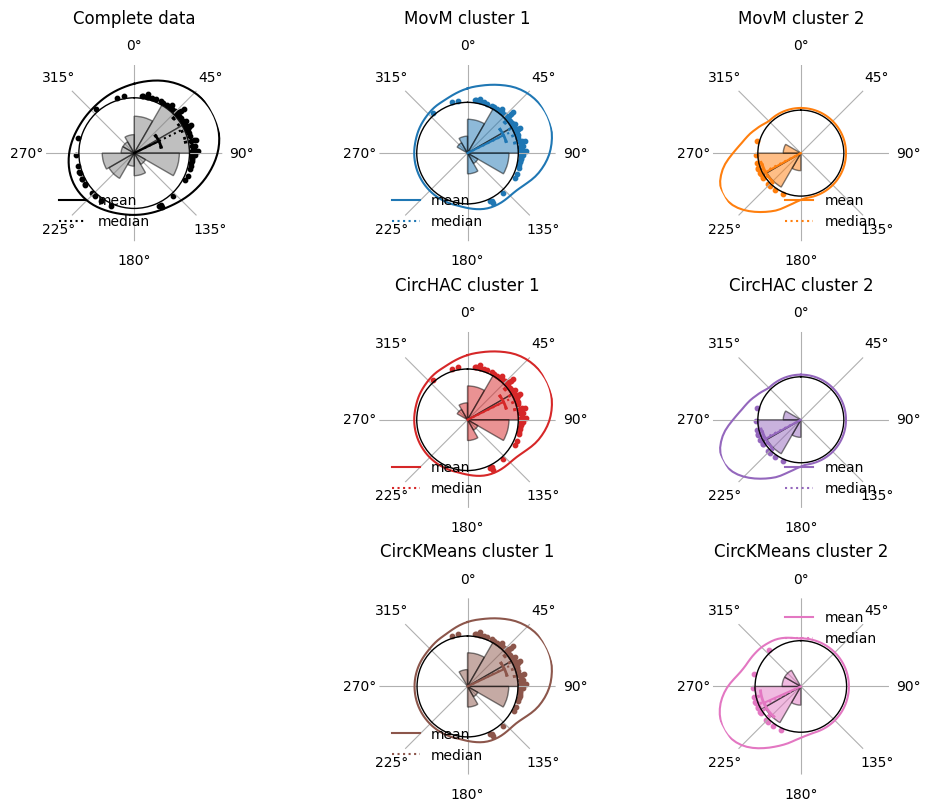

In [4]:
ax_labels = ["A", "B", "C", "D", "E", "F", "G"]
fig, ax = plt.subplot_mosaic(
    mosaic="""
    ABC
    .DE
    .FG
    """, figsize=(10, 8), 
    subplot_kw={"projection": "polar"},
    layout="constrained",
)

# complete data
c = Circular(d)
c.plot(ax=ax["A"])

for i, k in enumerate([1, 0]):

    # clustered data    
    x_k = movm.data[movm.labels_ == k]
    c_k = Circular(data=x_k, unit=movm.unit)

    c_k.plot(
        ax=ax[ax_labels[i+1]], 
        config={
            "density": {"color": f"C{i}"},
            "scatter": {"color": f"C{i}"},
            "mean": {"color": f"C{i}"},
            "median": {"color": f"C{i}"},
            "rose": {"color": f"C{i}"},
        }
    )

for i, k in enumerate([1, 0]):
    
    # clustered data    
    x_k = hac.data[hac.labels_ == k]
    c_k = Circular(data=x_k, unit=hac.unit)

    j = i + 3
    c_k.plot(
        ax=ax[ax_labels[j]], 
        config={
            "density": {"color": f"C{j}"},
            "scatter": {"color": f"C{j}"},
            "mean": {"color": f"C{j}"},
            "median": {"color": f"C{j}"},
            "rose": {"color": f"C{j}"},
        }
    )

for i, k in enumerate([0, 1]):
    
    # clustered data    
    x_k = ckm.data[ckm.labels_ == k]
    c_k = Circular(data=x_k, unit=ckm.unit)

    j = i + 5
    c_k.plot(
        ax=ax[ax_labels[j]], 
        config={
            "density": {"color": f"C{j}"},
            "scatter": {"color": f"C{j}"},
            "mean": {"color": f"C{j}"},
            "median": {"color": f"C{j}"},
            "rose": {"color": f"C{j}"},
        }
    )
    
ax["A"].set_title("Complete data", pad=30)
ax["B"].set_title("MovM cluster 1", pad=30)
ax["C"].set_title("MovM cluster 2", pad=30)
ax["D"].set_title("CircHAC cluster 1", pad=30)
ax["E"].set_title("CircHAC cluster 2", pad=30)
ax["F"].set_title("CircKMeans cluster 1", pad=30)
ax["G"].set_title("CircKMeans cluster 2", pad=30)

`MovM` is actually already built into the `Circular` class as an exploratory tool. By setting `n_clusters_max` when initializing the `Circular` data object, `MovM` will run `n_clusters_max` times, from 1 to `n_clusters_max`, and select the model with the lowest BIC as the optimal number of clusters.

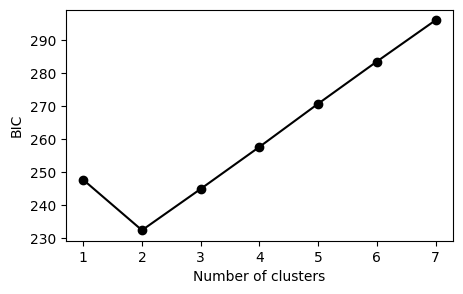

In [5]:
c = Circular(d, n_clusters_max=7)

fig, ax = plt.subplots(1, 1, figsize=(5, 3))
ax.plot(range(1, 8), c.mixtures_BIC, marker="o", c="black")
ax.set_xlabel("Number of clusters")
ax.set_ylabel("BIC")
plt.show()

In the dataset summary, the clustering result will be displayed on the second line (Unimodal?):

In [6]:
print(c.summary())

Circular Data

Summary
-------
  Grouped?: No
  Unimodal?: No (n_clusters=2) 
  Unit: degree
  Sample size: 76
  Angular mean: 64.17 ( p=0.0000 *** ) 
  Angular mean CI (0.95): 50.85 - 77.49
  Angular median: 64.00 
  Angular median CI (0.95): 48.00 - 78.00
  Angular deviation (s): 57.46 
  Circular standard deviation (s0): 67.74 
  Concentration (r): 0.50
  Concentration (kappa): 1.14
  Skewness: -0.082
  Kurtosis: 1.657

Signif. codes:
--------------
 0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Method
------
  Angular median: deviation
  Angular mean CI: dispersion



In [7]:
%load_ext watermark
%watermark --time --date --timezone --updated --python --iversions --watermark

Last updated: 2025-11-03 14:19:23CET

Python implementation: CPython
Python version       : 3.12.12
IPython version      : 9.6.0

pandas     : 2.3.3
numpy      : 2.3.4
matplotlib : 3.10.7
pycircstat2: 0.1.15

Watermark: 2.5.0

